In [95]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from specutils import Spectrum1D
from specutils.fitting import find_lines_threshold, find_lines_derivative
from scipy.optimize import curve_fit
from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [3]:
spectrum_files = glob(os.path.join('HST','anonymous37141', '*x1dsum.fits'))

In [67]:
# Load in RU Lupi data
# spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [6]:
spectrum_header = [fits.getheader(file, ext=0) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [7]:
date = [header['DATE'] for header in spectrum_header]
observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header]
instrument_filter = [header['OPT_ELEM'] for header in spectrum_header]

In [8]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
lab_emission_lines = lines['lab_lambda']
transition_grouped_lines = lines.groupby("[nu', J']")

In [78]:
spectrum_x1d[50]

SEGMENT,EXPTIME,NELEM,WAVELENGTH,FLUX,ERROR,ERROR_LOWER,GROSS,GCOUNTS,VARIANCE_FLAT,VARIANCE_COUNTS,VARIANCE_BKG,NET,BACKGROUND,DQ,DQ_WGT
,s,,Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),erg / (Angstrom s cm2),ct / s,ct,ct,ct,ct,ct / s,ct / s,,
bytes4,float64,int32,float64[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],float32[16384],int16[16384],float32[16384]
FUVA,439.008,16384,1574.175598677498 .. 1774.827438367698,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0
FUVB,439.008,16384,1385.9929259052471 .. 1586.5165840120032,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0


In [ ]:
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.concatenate(spectrum_x1d[0]['WAVELENGTH'])*u.AA
wavesort_idx = np.argsort(x1d_wavelength)
x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.concatenate(spectrum_x1d[0]['FLUX'])*flux_units
x1d_fluxerr = np.concatenate(spectrum_x1d[0]['ERROR'])*flux_units

x1d_flux = x1d_flux[wavesort_idx]
x1d_fluxerr = x1d_fluxerr[wavesort_idx]


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

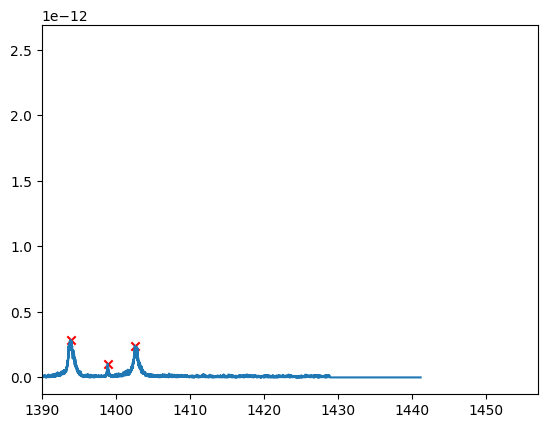

In [119]:
peaks , _ = find_peaks(x1d_flux, height=max(x1d_fluxerr.value), distance=100)
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [120]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

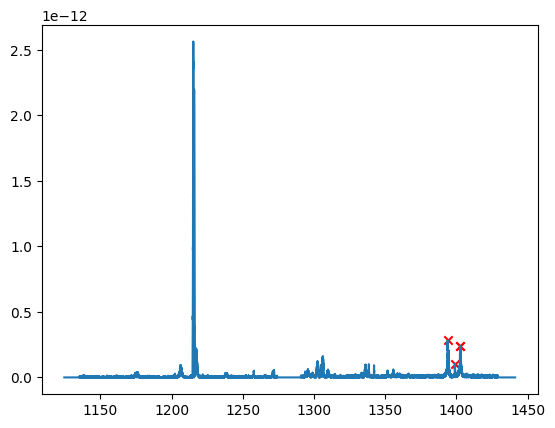

In [122]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [139]:
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-150:idx+150] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-150:idx+150] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-150:idx+150] for idx in x1d_h2_emissions_idx]

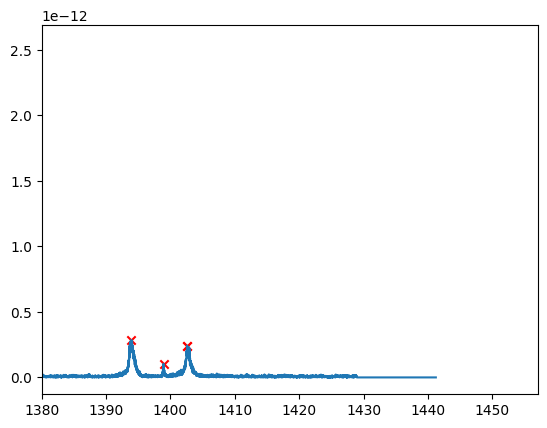

In [140]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [141]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = np.asarray(x1d_h2_emissions_flux)
fluxerr = np.asarray(x1d_h2_emissions_fluxerr)
wavelength = np.asarray(x1d_h2_emissions_wavelength)

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)


In [142]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

,Line ID,"[nu', J']",lab_lambda,spec_flux,spec_fluxerr,spec_wavelength
"[nu', J']",,,,,,
"[0,1]",(0–5)P(2),"[0,1]",1398.95,"[1.21163786e-14, 3.3364664e-15, 8.605035e-15, ...","[6.605128e-15, 4.614609e-15, 5.9240595e-15, 5....","[1397.4286755125863, 1397.4386400541223, 1397...."
"[0,2]",(0–5)P(3),"[0,2]",1402.65,"[2.1157536e-14, 1.4012364e-14, 3.366967e-14, 2...","[8.116929e-15, 7.0180144e-15, 9.681462e-15, 8....","[1401.085662256328, 1401.095626797864, 1401.10..."
"[0,3]",(0–5)R(2),"[0,3]",1395.20,"[2.205752e-14, 1.8625123e-14, 1.1750893e-14, 2...","[8.0651275e-15, 7.582982e-15, 6.474092e-15, 7....","[1392.4065465784015, 1392.4165111199375, 1392...."
"[0,3]",(0–5)P(4),"[0,3]",1407.29,"[2.1157536e-14, 1.4012364e-14, 3.366967e-14, 2...","[8.116929e-15, 7.0180144e-15, 9.681462e-15, 8....","[1401.085662256328, 1401.095626797864, 1401.10..."


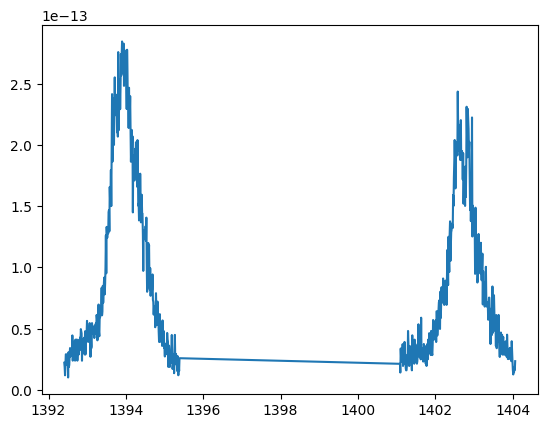

In [147]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function